Mode decomposition of emotional arcs!
----------------------------------------------

This second version uses only the linear algebra version of the SVD.

In [1]:
from os import listdir
from os.path import isfile, join
from json import loads
from re import findall,UNICODE
import sys
sys.path.append("/Users/andyreagan/tools/python")
from kitchentable.dogtoys import *
from labMTsimple.labMTsimple.speedy import LabMT
my_LabMT = LabMT()
from labMTsimple.labMTsimple.storyLab import *
import numpy as np
from database.bookclass import Book_raw_data
import pickle

import os
sys.path.append('/Users/andyreagan/projects/2014/09-books/database')
os.environ.setdefault('DJANGO_SETTINGS_MODULE','gutenbergdb.settings')
import django
django.setup()

from library.models import *

In [2]:
# all our essentials
from matplotlib import rc,rcParams
# rc('font', family='sans-serif') 
# rc('font', serif='Helvetica Neue')
# rc('text', usetex='false') 

rc('font', family='serif')
rc('font', family='cmr10')
rc('text', usetex='true') 

rcParams.update({'font.size': 12})
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from sklearn import metrics
from sklearn.cluster import KMeans
# from the demo
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.preprocessing import scale

In [118]:
q = Book.objects.filter(exclude=False,length__gt=10000,length__lte=200000,downloads__gte=150,numUniqWords__gt=1000,numUniqWords__lt=18000,lang_code_id=0)

In [120]:
print("there are {0} books".format(len(q)))
# check if the length information is in there...
print(q[0].title)
print(q[0].length)
print(q[0].numUniqWords)
print(len(q))
allLengths = [book.length for book in q]
print(max(allLengths))
allLengths.sort()

there are 1737 books
The Declaration of Independence of the United States of America
19879
3432
1737
199808


In [121]:
use_cache = True
version = "005"
if isfile("data/gutenberg/timeseries-matrix-cache-{}.p".format(version)) and use_cache:
    big_matrix = pickle.load(open("data/gutenberg/timeseries-matrix-cache-{}.p".format(version),"rb"))
else:
    # load all of the timeseries into a matrix
    big_matrix = np.ones([len(q),200])
    # big_matrix_mean0 = np.ones(big_matrix.shape)
    stop_val = 1.0
    for i,b in enumerate(q):
        if i%100 == 0:
            print(i)
        # print(b.title)
        b_data = Book_raw_data(b)
        a = b_data.chopper_sliding(my_LabMT,num_points=200,stop_val=stop_val)
        big_matrix[i,:] = b_data.timeseries
    print(big_matrix.shape)
    pickle.dump(big_matrix,open("data/gutenberg/timeseries-matrix-cache-{}.p".format(version),"wb"),pickle.HIGHEST_PROTOCOL)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
(1737, 200)


In [122]:
# this way takes the mean of all stories out
# big_matrix_mean0 = big_matrix-big_matrix.mean(axis=0)
# but I should do it individually...
# (not going to normalize, either)
# this is a really ugly way to do that:
big_matrix_mean0 = big_matrix-np.tile(big_matrix.mean(axis=1),(200,1)).transpose()

[ 5.86015566  5.86378075  5.85807055  5.86567697  5.86267838  5.86217091
  5.862322    5.86089846  5.85995208  5.85713376  5.85381558  5.84940959
  5.85458047  5.85954186  5.86340347  5.85610205  5.85435171  5.8559707
  5.85848247  5.85853493  5.85861371  5.85080206  5.84926742  5.84624488
  5.85239631  5.85462009  5.85329776  5.8585461   5.85674112  5.85860606
  5.85859383  5.85495935  5.85626843  5.85590816  5.85696429  5.85586137
  5.84499237  5.83484232  5.8332622   5.82976154  5.8306802   5.8325228
  5.82628543  5.8263774   5.83029293  5.83261569  5.832888    5.83219316
  5.83331825  5.83430514  5.83292044  5.83313795  5.8378125   5.83330649
  5.83349142  5.83427273  5.83065756  5.83282664  5.8277025   5.82505618
  5.81926192  5.81788066  5.81299743  5.81259526  5.81644628  5.82529412
  5.82979845  5.83607032  5.83352214  5.83719732  5.84403717  5.84436758
  5.84009269  5.83181677  5.83295431  5.83482848  5.83216371  5.827978
  5.82207478  5.82174142  5.82286243  5.8267214   5.818

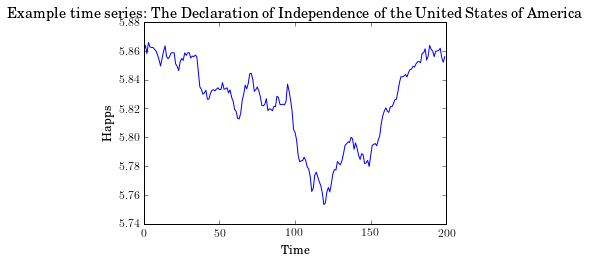

In [123]:
print(big_matrix[0,:])
fig = plt.figure()
ax = fig.add_axes([.2,.2,.7,.7])
ax.plot(big_matrix[0,:])
ax.set_xlabel("Time")
ax.set_ylabel("Happs")
ax.set_title("Example time series: {}".format(q[0].title))
mysavefig("example-timeseries.pdf",folder="media/figures/SVD",openfig=False)

[ 5.86015566  5.86378075  5.85807055  5.86567697  5.86267838  5.86217091
  5.862322    5.86089846  5.85995208  5.85713376  5.85381558  5.84940959
  5.85458047  5.85954186  5.86340347  5.85610205  5.85435171  5.8559707
  5.85848247  5.85853493  5.85861371  5.85080206  5.84926742  5.84624488
  5.85239631  5.85462009  5.85329776  5.8585461   5.85674112  5.85860606
  5.85859383  5.85495935  5.85626843  5.85590816  5.85696429  5.85586137
  5.84499237  5.83484232  5.8332622   5.82976154  5.8306802   5.8325228
  5.82628543  5.8263774   5.83029293  5.83261569  5.832888    5.83219316
  5.83331825  5.83430514  5.83292044  5.83313795  5.8378125   5.83330649
  5.83349142  5.83427273  5.83065756  5.83282664  5.8277025   5.82505618
  5.81926192  5.81788066  5.81299743  5.81259526  5.81644628  5.82529412
  5.82979845  5.83607032  5.83352214  5.83719732  5.84403717  5.84436758
  5.84009269  5.83181677  5.83295431  5.83482848  5.83216371  5.827978
  5.82207478  5.82174142  5.82286243  5.8267214   5.818

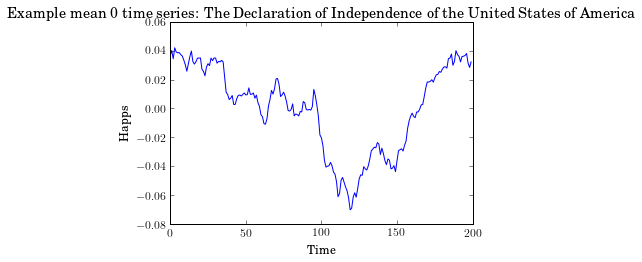

In [187]:
print(big_matrix[0,:])
fig = plt.figure()
ax = fig.add_axes([.2,.2,.7,.7])
ax.plot(big_matrix_mean0[0,:])
ax.set_xlabel("Time")
ax.set_ylabel("Happs")
ax.set_title("Example mean 0 time series: {}".format(q[0].title))
mysavefig("example-timeseries-mean0.pdf",folder="media/figures/SVD",openfig=False)

In [125]:
big_matrix.shape

(1737, 200)

In [126]:
def mode_plot_tight(title,modes,submodes,saveas,ylim=.15):
    num_x = 3
    num_y = len(modes)/num_x
    xspacing = .01
    yspacing = .01
    xoffset = .07
    yoffset = .07
    xwidth = (1.-xoffset)/(num_x)-xspacing
    yheight = (1.-yoffset)/(num_y)-yspacing
    print('xwidth is {0}'.format(xwidth))
    print('yheight is {0}'.format(yheight))

    fig = plt.figure(figsize=(7.5,10))
    for i,mode in enumerate(modes):
#         print(i)
#         print("====")
#         print((i-i%num_x))
        # ind = np.argsort(w[:,sv+svstart])[-20:]
        ax1rect = [xoffset+(i%num_x)*(xspacing+xwidth),1.-yheight-yspacing-(int(np.floor((i-i%num_x)/num_x))*(yspacing+yheight)),xwidth,yheight]
        ax1 = fig.add_axes(ax1rect)
        # plt.subplot(4,3,i+1)
        ax1.plot(submodes[i],color=".4",linewidth=1.5)
        ax1.plot(modes[i],color=".1",linewidth=1.5)
        ax1.set_ylim([-ylim,ylim])
        if not i%num_x == 0:
            ax1.set_yticklabels([])
            if int(np.floor((i-i%num_x)/num_x)) == num_y-1:
                ax1.set_xticks([50,100,150,200])
        if not int(np.floor((i-i%num_x)/num_x)) == num_y-1:
            ax1.set_xticklabels([])
#         if int(np.floor((i-i%num_x)/num_x)) == num_y-1 and i%num_x == 1:
#             ax1.set_xlabel("Time")
#         if i == 0:
#             new_ticks = [x for x in ax1.yaxis.get_ticklocs()]
#             ax1.set_yticks(new_ticks)
#             new_ticklabels = [str(x) for x in new_ticks]
#             new_ticklabels[-1] = "Happs"
#             # ax1.set_yticklabels(new_ticklabels)
        props = dict(boxstyle='square', facecolor='white', alpha=1.0)
        # fig.text(ax1rect[0]+.03/xwidth, ax1rect[1]+ax1rect[3]-.03/yheight, letters[i],
        my_ylim = [-ylim,ylim]
        ax1.text(.035*200, my_ylim[0]+.965*(my_ylim[1]-my_ylim[0]), "{0}".format(i),
                     fontsize=14,
                     verticalalignment='top',
                     horizontalalignment='left',
                     bbox=props)
        if i%num_x == 0:
            # new_ticks = [x for x in ax1.yaxis.get_ticklocs()]
            # ax1.set_yticks(new_ticks[:-2])
            ax1.set_yticks([-.1,0,.1])
    fig.text((1.-xoffset)/2.+xoffset,yoffset/2.,"Percentage of book",verticalalignment='center', horizontalalignment='center',fontsize=15) #,horizontalalign="center")    
    # plt.subplot(4,3,2)
    fig.text(0,(1.-yoffset)/2.+yoffset,r"h_{\textnormal{avg}}",verticalalignment='center', horizontalalignment='center',fontsize=15,rotation=90) #,horizontalalign="center"
    
    # mysavefig('pca-MLEcomponents-first12.png')
    mysavefig(saveas,folder="media/figures/SVD",openfig=False)
    
# weighted = [svd2.components_[i]*svd2.explained_variance_ratio_[i]/svd2.explained_variance_ratio_[0] for i in range(12)]
# mode_plot_tight("SVD Mean 0 Components for {} books, unweighted".format(len(q)),svd2.components_,weighted,"SVD-timeseries-unweighted-mean0.pdf")

(array([  2.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,   2.,
          0.,   0.,   4.,   0.,   0.,   1.,   1.,   0.,   2.,   3.,   0.,
          3.,   1.,   4.,   3.,   2.,   2.,   7.,   6.,   6.,  14.,   6.,
         12.,  15.,  12.,  12.,  12.,  17.,  17.,  11.,  35.,  27.,  27.,
         20.,  27.,  28.,  36.,  29.,  56.,  33.,  32.,  67.,  46.,  48.,
         49.,  44.,  45.,  52.,  58.,  61.,  57.,  71.,  54.,  59.,  39.,
         53.,  41.,  31.,  38.,  32.,  28.,  25.,  20.,  21.,  25.,  23.,
         11.,  16.,  14.,   7.,  11.,   8.,   9.,   8.,   4.,   4.,  10.,
          2.,   3.,   5.,   2.,   0.,   3.,   1.,   1.,   0.,   0.,   1.,
          1.]),
 array([ 4.90561859,  4.91938786,  4.93315713,  4.94692641,  4.96069568,
         4.97446495,  4.98823423,  5.0020035 ,  5.01577277,  5.02954205,
         5.04331132,  5.05708059,  5.07084987,  5.08461914,  5.09838841,
         5.11215769,  5.12592696,  5.13969623,  5.15346551,  5.16723478,
         5.18100405,  5.19

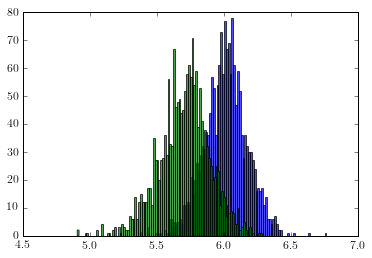

In [127]:
allMax = np.amax(big_matrix,axis=1)
allMin = np.amin(big_matrix,axis=1)
plt.hist(allMax,bins=100,alpha=0.7)
plt.hist(allMin,bins=100,alpha=0.7)

In [128]:
U,S,V = np.linalg.svd(big_matrix_mean0,full_matrices=True,compute_uv=True)

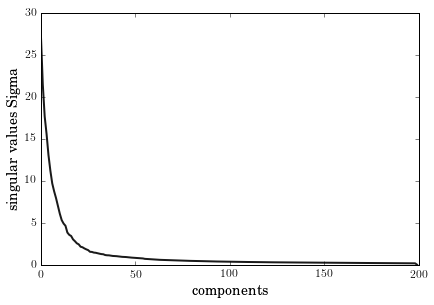

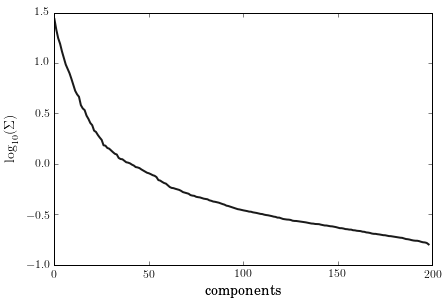

In [129]:
fig = plt.figure(figsize=(7.5,5))
ax1 = fig.add_axes([0.2,0.2,0.7,0.7])
ax1.plot(S,linewidth=2,color=".1")
ax1.set_ylabel('singular values Sigma',fontsize=14)
ax1.set_xlabel('components',fontsize=14)
# mysavefig('pca-{0}components-explainedvariance-mean0.png'.format(pca.n_components_))
mysavefig("SVD-variance-numpy.pdf",folder="media/figures/SVD",openfig=False)

fig = plt.figure(figsize=(7.5,5))
ax1 = fig.add_axes([0.2,0.2,0.7,0.7])
ax1.plot(np.log10(S[:-1]),color=".1",linewidth=2)
ax1.set_ylabel('$\log_{10}(\Sigma)$',fontsize=14)
ax1.set_xlabel('components',fontsize=14)
# mysavefig('pca-{0}components-explainedvariance-mean0.png'.format(pca.n_components_))
mysavefig("SVD-log10variance-numpy.pdf",folder="media/figures/SVD",openfig=False)

In [130]:
print(U.shape)
print(S.shape)
print(V.shape)

(1737, 1737)
(200,)
(200, 200)


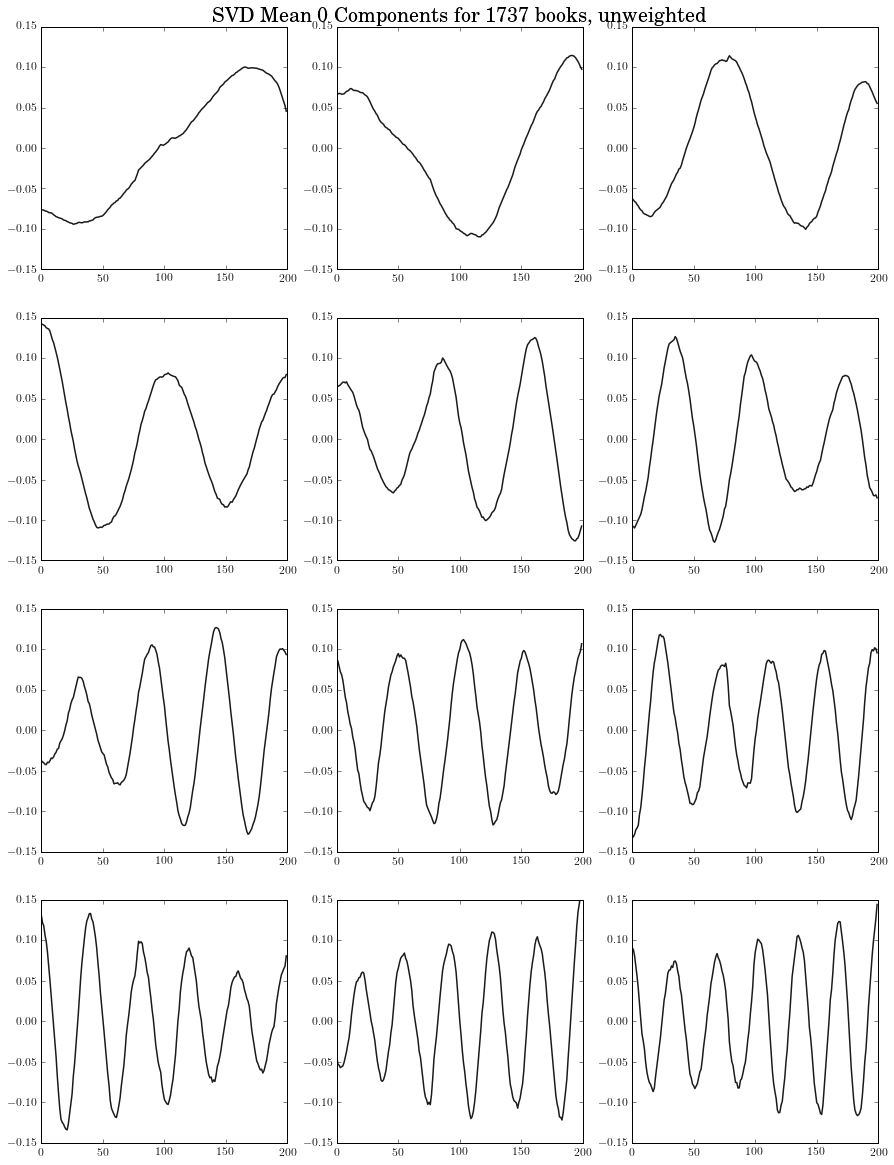

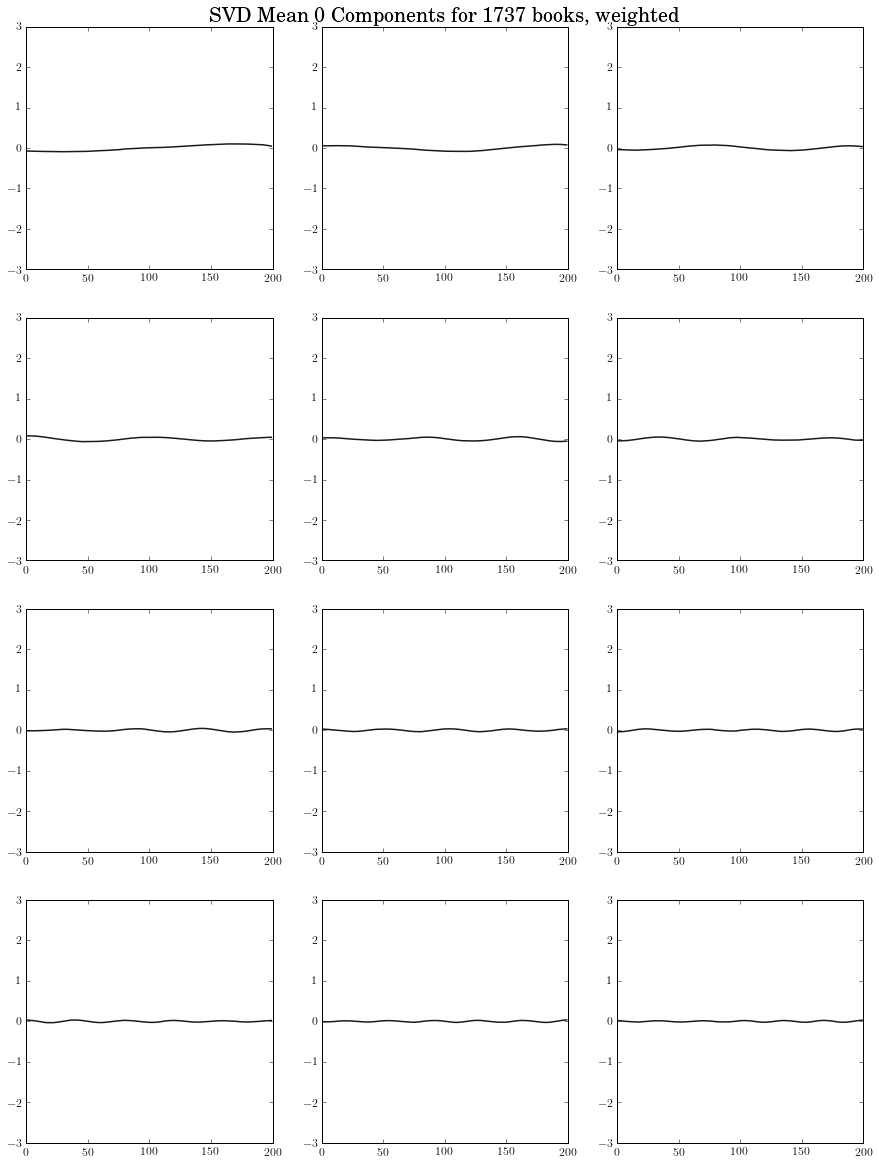

In [131]:
fig = plt.figure(figsize=(15,20))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(V[i,:],color=".1",linewidth=1.5)
    plt.ylim([-.15,.15])
plt.subplot(4,3,2)
plt.title("SVD Mean 0 Components for {} books, unweighted".format(len(q)),fontsize=20)
# mysavefig('pca-MLEcomponents-first12.png')
mysavefig("SVD-timeseries-unweighted-mean0-numpy.pdf",folder="media/figures/SVD",openfig=False)

fig = plt.figure(figsize=(15,20))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(V[i,:]*S[i]/S[0],color=".1",linewidth=1.5)
    plt.ylim([-3,3])
plt.subplot(4,3,2)
plt.title("SVD Mean 0 Components for {} books, weighted".format(len(q)),fontsize=20)
mysavefig("SVD-timeseries-weighted-mean0-numpy.pdf",folder="media/figures/SVD",openfig=False)

In [132]:
S[:20]

array([ 27.34757784,  21.45221211,  17.64713343,  15.54974413,
        13.05574024,  11.19788098,   9.66736   ,   8.73193035,
         7.92723527,   6.97519868,   6.06866633,   5.30422122,
         4.89321489,   4.62908871,   3.82543715,   3.54808784,
         3.41371222,   3.00891787,   2.79333619,   2.54397356])

### Now let's use the SVD's USV matrices to examine how each mode contributes

Start by constructing w, the intermediate product U*S

In [133]:
# print(U[0,0]*S[0])
# print(U[0,:200]*S)
w = U[:,:200]*S
# each row entry of w are the contribution of each mode to the timeseries for book i
# where all of book i's entries are in row i
# so, the contribution from mode 1 to all books is column 1
print(w.shape)

(1737, 200)


-1.95208847187
5.17433582266


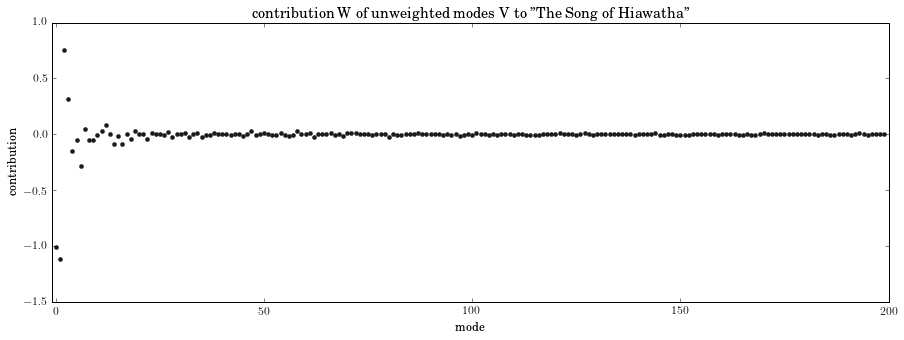

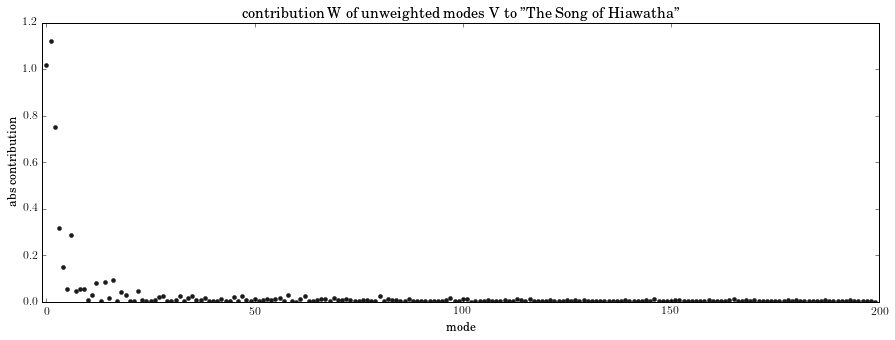

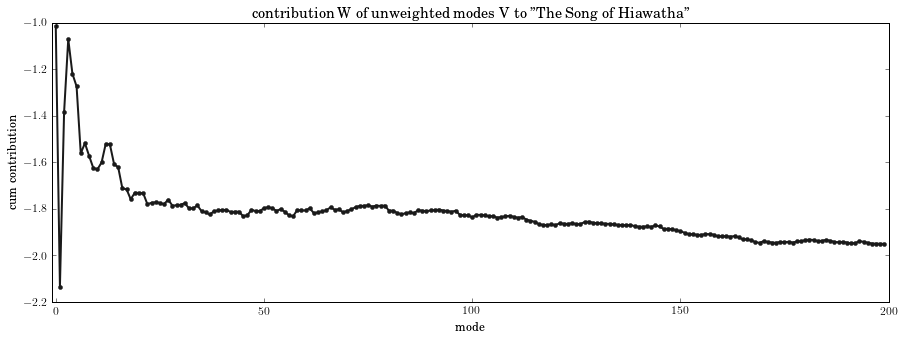

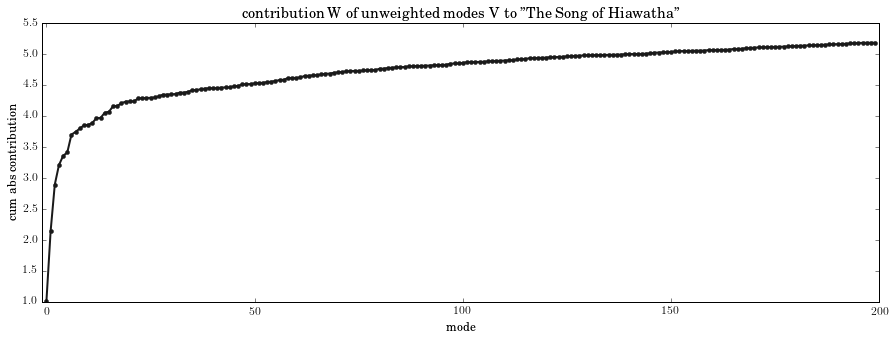

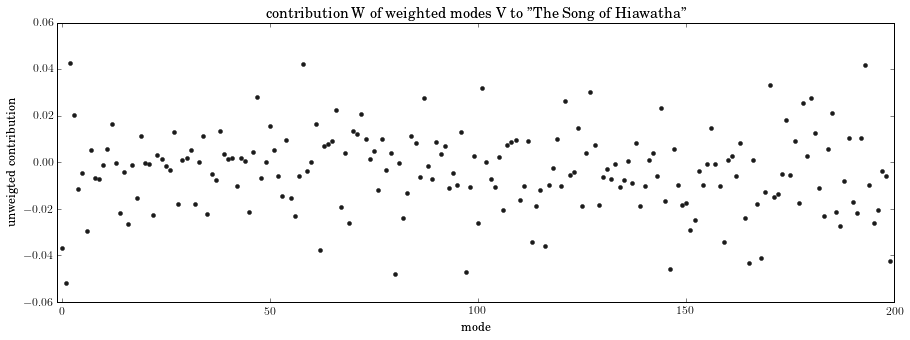

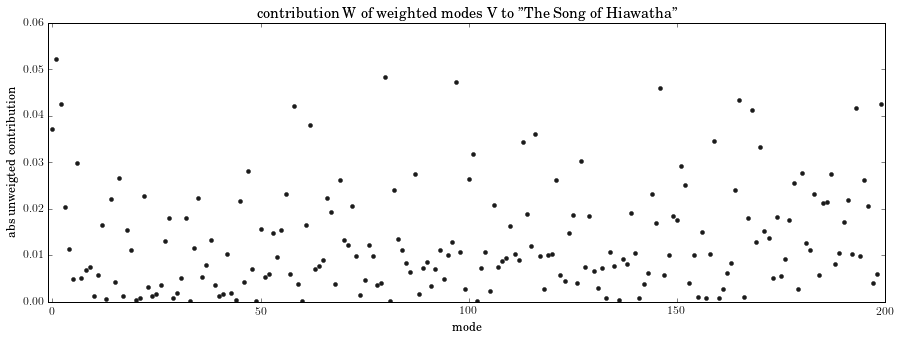

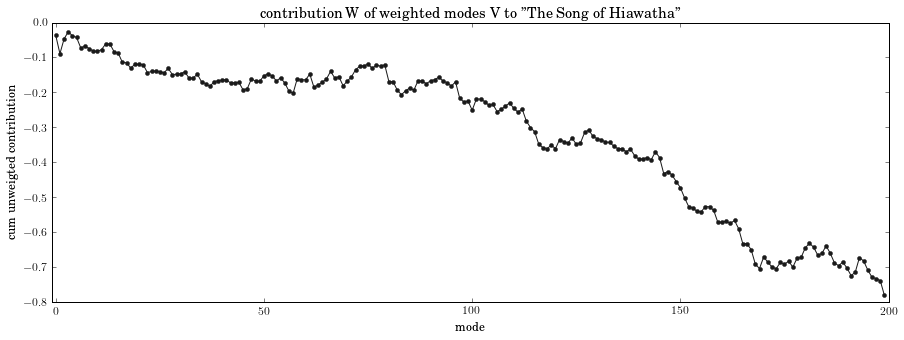

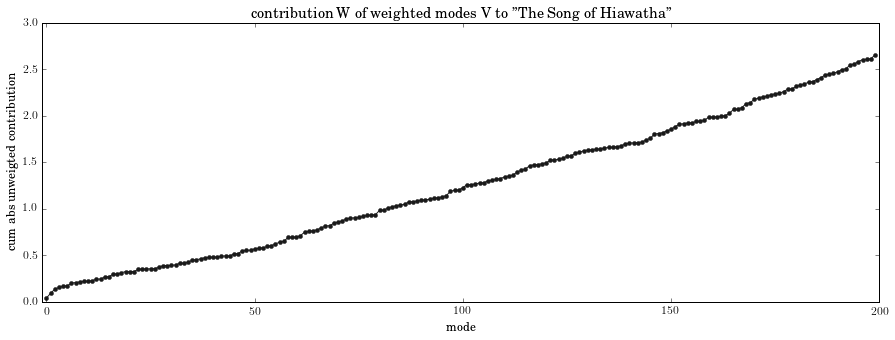

In [134]:
i = 5
print(w[i,:].sum())
print(np.abs(w[i,:]).sum())
plt.figure(figsize=(15,5))
plt.plot(w[i,:],".",color=".1",linewidth=1,markersize=8)
plt.xlim([-1,200])
plt.title('contribution W of unweighted modes V to "{0}"'.format(q[i].title))
plt.xlabel('mode')
plt.ylabel('contribution')
mysavefig("SVD-coeff-W-unweighted.pdf",folder="media/figures/SVD",openfig=False)

plt.figure(figsize=(15,5))
plt.plot(np.abs(w[i,:]),".",color=".1",linewidth=1,markersize=8)
plt.xlim([-1,200])
plt.title('contribution W of unweighted modes V to "{0}"'.format(q[i].title))
plt.xlabel('mode')
plt.ylabel('abs contribution')
mysavefig("SVD-coeff-W-unweighted-abs.pdf",folder="media/figures/SVD",openfig=False)

plt.figure(figsize=(15,5))
plt.plot(np.cumsum(w[i,:]),".-",color=".1",linewidth=2,markersize=8)
plt.xlim([-1,200])
plt.title('contribution W of unweighted modes V to "{0}"'.format(q[i].title))
plt.xlabel('mode')
plt.ylabel('cum contribution')
mysavefig("SVD-coeff-W-unweighted-cumsum.pdf",folder="media/figures/SVD",openfig=False)

plt.figure(figsize=(15,5))
plt.plot(np.cumsum(np.abs(w[i,:])),".-",color=".1",linewidth=2,markersize=8)
plt.xlim([-1,200])
plt.title('contribution W of unweighted modes V to "{0}"'.format(q[i].title))
plt.xlabel('mode')
plt.ylabel('cum abs contribution')
mysavefig("SVD-coeff-W-unweighted-abs-cumsum.pdf",folder="media/figures/SVD",openfig=False)

plt.figure(figsize=(15,5))
plt.plot(U[i,:200],".",color=".1",linewidth=1,markersize=8)
plt.xlim([-1,200])
plt.title('contribution W of weighted modes V to "{0}"'.format(q[i].title))
plt.xlabel('mode')
plt.ylabel('unweigted contribution')
mysavefig("SVD-coeff-W-weighted.pdf",folder="media/figures/SVD",openfig=False)

plt.figure(figsize=(15,5))
plt.plot(np.abs(U[i,:200]),".",color=".1",linewidth=1,markersize=8)
plt.xlim([-1,200])
plt.title('contribution W of weighted modes V to "{0}"'.format(q[i].title))
plt.xlabel('mode')
plt.ylabel('abs unweigted contribution')
mysavefig("SVD-coeff-W-weighted-abs.pdf",folder="media/figures/SVD",openfig=False)

plt.figure(figsize=(15,5))
plt.plot(np.cumsum(U[i,:200]),".-",color=".1",linewidth=1,markersize=8)
plt.xlim([-1,200])
plt.title('contribution W of weighted modes V to "{0}"'.format(q[i].title))
plt.xlabel('mode')
plt.ylabel('cum unweigted contribution')
mysavefig("SVD-coeff-W-weighted-cumsum.pdf",folder="media/figures/SVD",openfig=False)

plt.figure(figsize=(15,5))
plt.plot(np.cumsum(np.abs(U[i,:200])),".-",color=".1",linewidth=1,markersize=8)
plt.xlim([-1,200])
plt.title('contribution W of weighted modes V to "{0}"'.format(q[i].title))
plt.xlabel('mode')
plt.ylabel('cum abs unweigted contribution')
mysavefig("SVD-coeff-W-weighted-abs-cumsum.pdf",folder="media/figures/SVD",openfig=False)

In [135]:
np.abs(w[:10,:]).sum(axis=1)

array([ 1.66829253,  1.91354158,  2.42114303,  4.57845793,  5.90310544,
        5.17433582,  9.40280011,  3.44942261,  4.50251701,  4.66341649])

the sum of coefficients is not normalized across the books, some have more energy? they might just have greater contributions by books with smaller weighted timeseries (I've used the singular values here)

### Now use that to reconstruct the full time series from the modes (sanity check)

In [188]:
# squeeze w into the right shape
# transpose doesn't really do it
t = np.dot(np.reshape(w[0,:],(1,200)),V)
print(np.reshape(w[0,:],(1,200)).shape)
print(V.shape)
print(t.shape)
# squeeze w into the right shape
# transpose doesn't really do it
t = np.dot(w,V)
print(V.shape)
print(t.shape)

(1, 200)
(200, 200)
(1, 200)
(200, 200)
(1737, 200)


ValueError: operands could not be broadcast together with shapes (1737,200) (200,200) 

[ 5.86015566  5.86378075  5.85807055  5.86567697  5.86267838  5.86217091
  5.862322    5.86089846  5.85995208  5.85713376]
[ 0.03651143  0.04013651  0.03442632  0.04203274  0.03903415  0.03852668
  0.03867776  0.03725422  0.03630784  0.03348952]


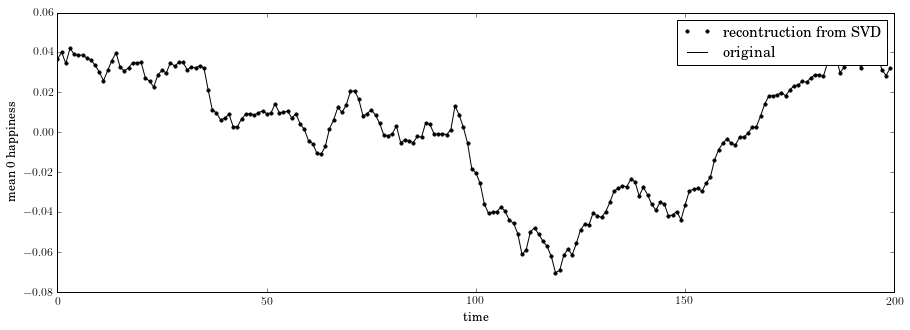

In [137]:
print(big_matrix[0,:10])
print(t[0,:10])
plt.figure(figsize=(15,5))
plt.plot(t[0,:],'k.',markersize=7)
plt.plot(big_matrix[0,:]-np.mean(big_matrix[0,:]),'k-')
plt.legend(["recontruction from SVD","original"])
plt.xlabel("time")
plt.ylabel("mean 0 happiness")
mysavefig("example-timeseries-reconstruction.pdf",folder="media/figures/SVD",openfig=False)

## Look at the books that have most variance explained by individual modes

Going to normalize first within each book so that the coefficients add to 1.

Choosing to do this in W (could also use U).

Just depends whether putting S into U or V (here, putting it into U).

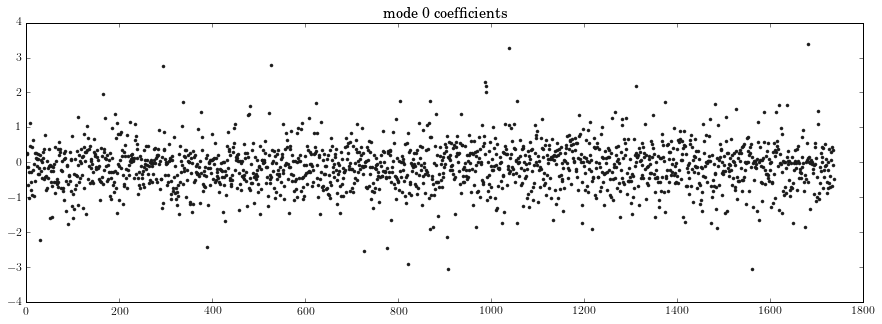

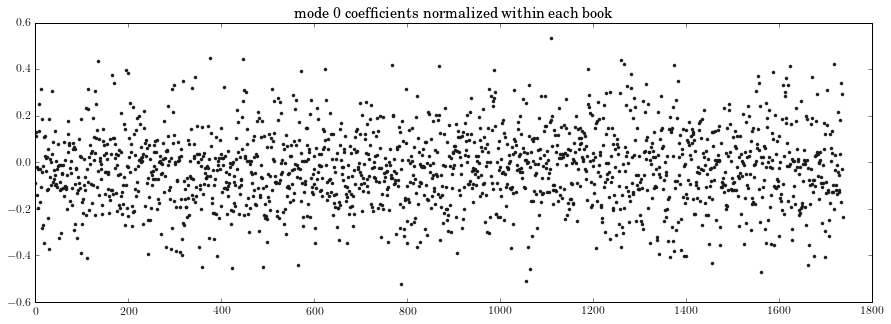

In [138]:
plt.figure(figsize=(15,5))
plt.plot(w[:,0],".",color=".1")
plt.title("mode 0 coefficients")
mysavefig("SVD-coeff-W-mode0-all.pdf",folder="media/figures/SVD",openfig=False)

w_abs = np.abs(w)
w_normalized = np.multiply(w,np.tile(1./w_abs.sum(axis=1),(200,1)).transpose())
plt.figure(figsize=(15,5))
plt.plot(w_normalized[:,0],".",color=".1")
plt.title("mode 0 coefficients normalized within each book")
mysavefig("SVD-coeff-W-mode0-all-norm.pdf",folder="media/figures/SVD",openfig=False)

xwidth is 0.3
yheight is 0.22249999999999998


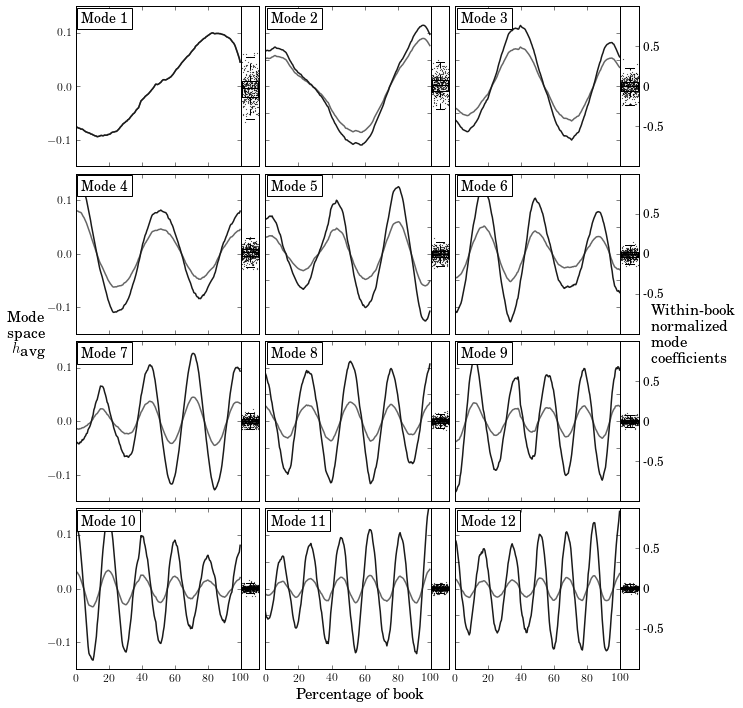

In [139]:
num_x = 3
num_y = 12/num_x
xspacing = .01
yspacing = .01
xoffset = .07
yoffset = .07
xwidth = (1.-xoffset)/(num_x)-xspacing
yheight = (1.-yoffset)/(num_y)-yspacing
print('xwidth is {0}'.format(xwidth))
print('yheight is {0}'.format(yheight))
ylim = .15

fig = plt.figure(figsize=(8.5,10))
for i in range(12):
#         print(i)
#         print("====")
#         print((i-i%num_x))
    # ind = np.argsort(w[:,sv+svstart])[-20:]
    ax1rect = [xoffset+(i%num_x)*(xspacing+xwidth),1.-yheight-yspacing-(int(np.floor((i-i%num_x)/num_x))*(yspacing+yheight)),xwidth*.9,yheight]
    ax2rect = ax1rect.copy()
    ax2rect[0] += ax1rect[2]
    ax2rect[2] = (1-.9)*xwidth
    ax1 = fig.add_axes(ax1rect)
    ax2 = fig.add_axes(ax2rect)
    ax2.set_ylim([-1,1])
    ax2.set_xlim([.5,1.5])
    w_subset = np.random.choice(w_normalized[:,i],400)
    x_values = .55+.9*np.random.rand(400)
    ax2.scatter(x_values,
                w_subset,
                facecolor="k",
                edgecolor=None,
                linewidth=0.0,
                s=3.5,
                # edgewidth=0.0,
                alpha=0.1)
    ax2.scatter(x_values,
                w_subset,
                facecolor="k",
                edgecolor=None,
                linewidth=0.0,
                s=.7,
                # edgewidth=0.0,
                alpha=0.7)
    p = [np.percentile(w_normalized[:,i],50),
         np.percentile(w_normalized[:,i],50),
         np.percentile(w_normalized[:,i],50)]
    boxprops = dict(linestyle='-', linewidth=1.0, color='k')
    medianprops = dict(linestyle='--', linewidth=1.0, color='k')
    # meanlineprops = dict(linestyle='--', linewidth=2.5, color='purple')
    ax2.boxplot(w_normalized[:,i],
               showfliers=False,
               boxprops=boxprops,
               medianprops=boxprops,
               whiskerprops=medianprops,
               widths=.9)
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_xticklabels([])
    ax2.set_yticklabels([])
    # plt.subplot(4,3,i+1)
    ax1.plot(np.arange(0,100,0.5),V[i,:]*S[i]/S[0],color=".4",linewidth=1.5)
    ax1.plot(np.arange(0,100,0.5),V[i,:],color=".1",linewidth=1.5)
    ax1.set_ylim([-ylim,ylim])
    if not i%num_x == 0:
        ax1.set_yticklabels([])
    if i%num_x == (num_x-1):
        ax2.yaxis.tick_right()
        ax2.set_yticks([-.5,0,.5])
        ax2.set_yticklabels([-.5,0,.5])
#         if int(np.floor((i-i%num_x)/num_x)) == num_y-1:
#             ax1.set_xticks([25,50,75])
    if not int(np.floor((i-i%num_x)/num_x)) == num_y-1:
        ax1.set_xticklabels([])
#         if int(np.floor((i-i%num_x)/num_x)) == num_y-1 and i%num_x == 1:
#             ax1.set_xlabel("Time")
#         if i == 0:
#             new_ticks = [x for x in ax1.yaxis.get_ticklocs()]
#             ax1.set_yticks(new_ticks)
#             new_ticklabels = [str(x) for x in new_ticks]
#             new_ticklabels[-1] = "Happs"
#             # ax1.set_yticklabels(new_ticklabels)
    props = dict(boxstyle='square', facecolor='white', alpha=1.0)
    # fig.text(ax1rect[0]+.03/xwidth, ax1rect[1]+ax1rect[3]-.03/yheight, letters[i],
    my_ylim = ax1.get_ylim()
    # my_ylim = [-ylim,ylim]
    ax1.text(.035*100, my_ylim[0]+.965*(my_ylim[1]-my_ylim[0]), "Mode {0}".format(i+1),
                 fontsize=14,
                 verticalalignment='top',
                 horizontalalignment='left',
                 bbox=props)
    if i%num_x == 0:
        # new_ticks = [x for x in ax1.yaxis.get_ticklocs()]
        # ax1.set_yticks(new_ticks[:-2])
        ax1.set_yticks([-.1,0,.1])
        
fig.text((1.-xoffset)/2.+xoffset,yoffset/2.,"Percentage of book",verticalalignment='center', horizontalalignment='center',fontsize=15) #,horizontalalign="center")    
# plt.subplot(4,3,2)
# fig.text(0,(1.-yoffset)/2.+yoffset,r"Mode space $h_{\textnormal{avg}}$",verticalalignment='center', horizontalalignment='center',fontsize=15,rotation=90) #,horizontalalign="center"
# fig.text(1.05,(1.-yoffset)/2.+yoffset,r"Within-book normalized mode coefficients",verticalalignment='center', horizontalalignment='center',fontsize=15,rotation=-90) #,horizontalalign="center"
fig.text(0.02,(1.-yoffset)/2.+yoffset,r"""Mode
space
$h_{\textnormal{avg}}$""",verticalalignment='center', horizontalalignment="right",fontsize=15,rotation=0) #,horizontalalign="center"
fig.text(1.01,(1.-yoffset)/2.+yoffset,"Within-book\nnormalized\nmode\ncoefficients",verticalalignment='center', horizontalalignment='left',fontsize=15,rotation=0) #,horizontalalign="center"

mysavefig("SVD-timeseries-unweighted-mean0.pdf",folder="media/figures/SVD",openfig=True)

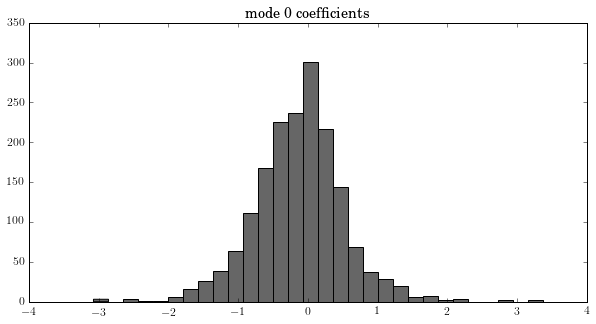

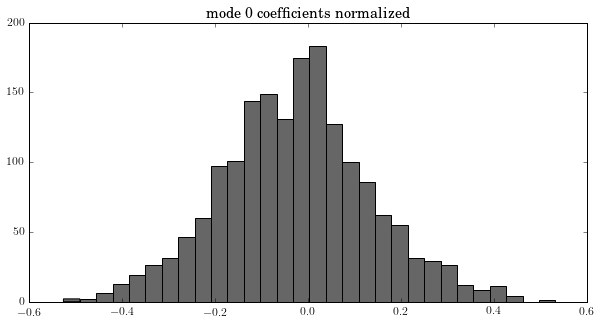

In [140]:
plt.figure(figsize=(10,5))
plt.title("mode 0 coefficients")
a = plt.hist(w[:,0],bins=30,color=".4")
mysavefig("SVD-coeff-W-mode0-all-hist.pdf",folder="media/figures/SVD",openfig=False)

plt.figure(figsize=(10,5))
plt.title("mode 0 coefficients normalized")
a = plt.hist(w_normalized[:,0],bins=30,color=".4")
mysavefig("SVD-coeff-W-mode0-all-norm-hist.pdf",folder="media/figures/SVD",openfig=False)

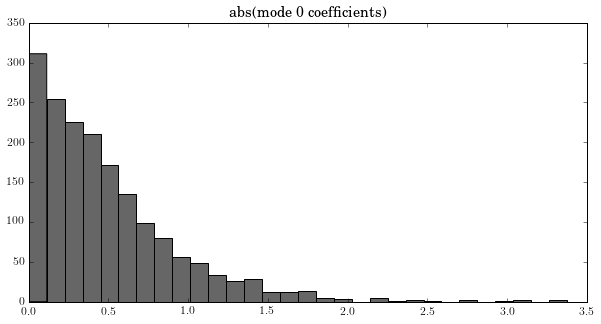

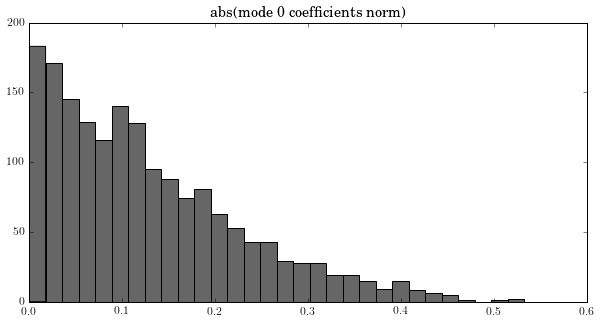

In [141]:
plt.figure(figsize=(10,5))
plt.title("abs(mode 0 coefficients)")
a = plt.hist(np.abs(w[:,0]),bins=30,color=".4")
mysavefig("SVD-coeff-W-mode0-all-hist-abs.pdf",folder="media/figures/SVD",openfig=False)

plt.figure(figsize=(10,5))
plt.title("abs(mode 0 coefficients norm)")
a = plt.hist(np.abs(w_normalized[:,0]),bins=30,color=".4")
mysavefig("SVD-coeff-W-mode0-all-norm-hist-abs.pdf",folder="media/figures/SVD",openfig=False)

In [142]:
mode_0_top_abs = sorted(zip(q,w[:,0],range(len(q))),key=lambda x: np.abs(x[1]),reverse=True)
mode_0_top_pos = sorted(zip(q,w[:,0],range(len(q))),key=lambda x: -x[1])
mode_0_top_neg = sorted(zip(q,w[:,0],range(len(q))),key=lambda x: x[1])
mode_0_top_abs_norm = sorted(zip(q,w_normalized[:,0],range(len(q))),key=lambda x: np.abs(x[1]),reverse=True)
mode_0_top_pos_norm = sorted(zip(q,w_normalized[:,0],range(len(q))),key=lambda x: -x[1])
mode_0_top_neg_norm = sorted(zip(q,w_normalized[:,0],range(len(q))),key=lambda x: x[1])

In [143]:
print("raw")
print(mode_0_top_abs[:2])
print(mode_0_top_pos[:2])
print(mode_0_top_neg[:2])
print("normalized")
print(mode_0_top_abs_norm[:2])
print(mode_0_top_pos_norm[:2])
print(mode_0_top_neg_norm[:2])

raw
[(<Book: A Book of Dartmoor
Second Edition>, 3.3763131185191737, 1681), (<Book: The Ladies' Work-Book
Containing Instructions In Knitting, Crochet, Point-Lace, etc.>, 3.2746517168105598, 1037)]
[(<Book: A Book of Dartmoor
Second Edition>, 3.3763131185191737, 1681), (<Book: The Ladies' Work-Book
Containing Instructions In Knitting, Crochet, Point-Lace, etc.>, 3.2746517168105598, 1037)]
[(<Book: The Principles of Masonic Law
A Treatise on the Constitutional Laws, Usages and Landmarks of
Freemasonry>, -3.0722749024406797, 907), (<Book: Savrola
A Tale of the Revolution in Laurania>, -3.0605435105267724, 1560)]
normalized
[(<Book: Alice's Adventures Under Ground
Being a facsimile of the original Ms. book afterwards developed into "Alice's Adventures in Wonderland">, 0.53271295622647352, 1109), (<Book: A Primary Reader: Old-time Stories, Fairy Tales and Myths Retold by Children>, -0.52545511632918951, 786)]
[(<Book: Alice's Adventures Under Ground
Being a facsimile of the original Ms. bo

3.37631311852 A Book of Dartmoor
Second Edition
3.27465171681 The Ladies' Work-Book
Containing Instructions In Knitting, Crochet, Point-Lace, etc.
2.77646889964 The Common Law
2.74513247859 Divine Comedy, Longfellow's Translation, Complete
2.29009544919 Mob Rule in New Orleans
Robert Charles and His Fight to Death, the Story of His Life, Burning Human Beings Alive, Other Lynching Statistics
2.19291859115 Astounding Stories of Super-Science February 1930
2.1856480137 The Red Record
Tabulated Statistics and Alleged Causes of Lynching in the United States
2.0143741116 Cicero's Tusculan Disputations
Also, Treatises On The Nature Of The Gods, And On The Commonwealth
1.94448362751 The Road to Oz
1.75586838324 Camp Life in the Woods and the Tricks of Trapping and Trap Making


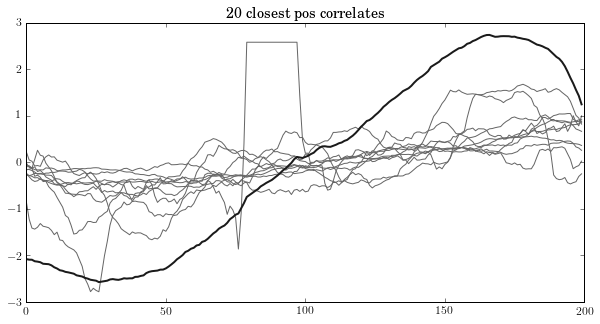

In [144]:
plt.figure(figsize=(10,5))
plt.title('20 closest pos correlates')
for b,s,i in mode_0_top_pos[:10]:
    # multiply each by the contribution (why?)
    plt.plot(big_matrix_mean0[i]*s,color=".4")
    print(s,b.title)
# weighted mode
plt.plot(V[0,:]*S[0],color=".1",linewidth=2)

0.532712956226 Alice's Adventures Under Ground
Being a facsimile of the original Ms. book afterwards developed into "Alice's Adventures in Wonderland"
0.447416382437 Dreams
0.443574760541 The Human Comedy: Introductions and Appendix
0.438737219615 The History Of The Decline And Fall Of The Roman Empire
Table of Contents with links in the HTML file to the two
Project Gutenberg editions (12 volumes)
0.435226386826 The Ballad of Reading Gaol
0.423592812272 A Coffin for Jacob
0.422346158367 Handbook of Wool Knitting and Crochet
0.419578114548 Eureka: A Prose Poem
0.418115068024 Adventures of Huckleberry Finn, Chapters 01 to 05
0.413868409342 More About the Squirrels


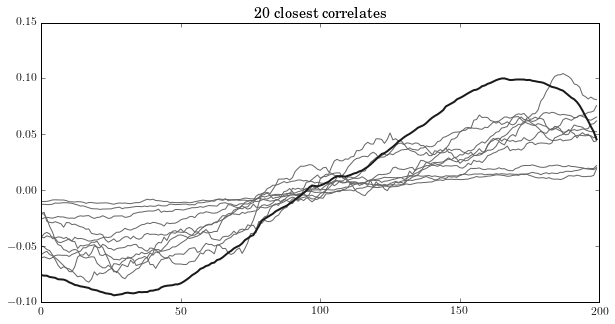

In [145]:
plt.figure(figsize=(10,5))
plt.title('20 closest correlates')
j = 0
for b,s,i in mode_0_top_pos_norm[:10]:
    plt.plot(big_matrix_mean0[i]*s,color=".4")
    # plt.plot(big_matrix_mean0[i],color=".4")
    print(s,b.title)
    j += 1
# plt.plot(V[0,:]*S[0],color=".1",linewidth=2)
plt.plot(V[0,:],color=".1",linewidth=2)

## Note:

Not a simple story here about each of these timeseries are explained by the modes.

They each have effectively a coefficient for the mode,
and so to show the stories and the mode on the same plot,
it really only makes sense to do so one at a time.

For each book, I can put the coefficients on each mode and show those modes.
But, if I show a bunch of different books, they all have different coefficients.
*I could try to normalize each book timeseries by it's energy...*

Here is a look at the reconstruction of a single book:

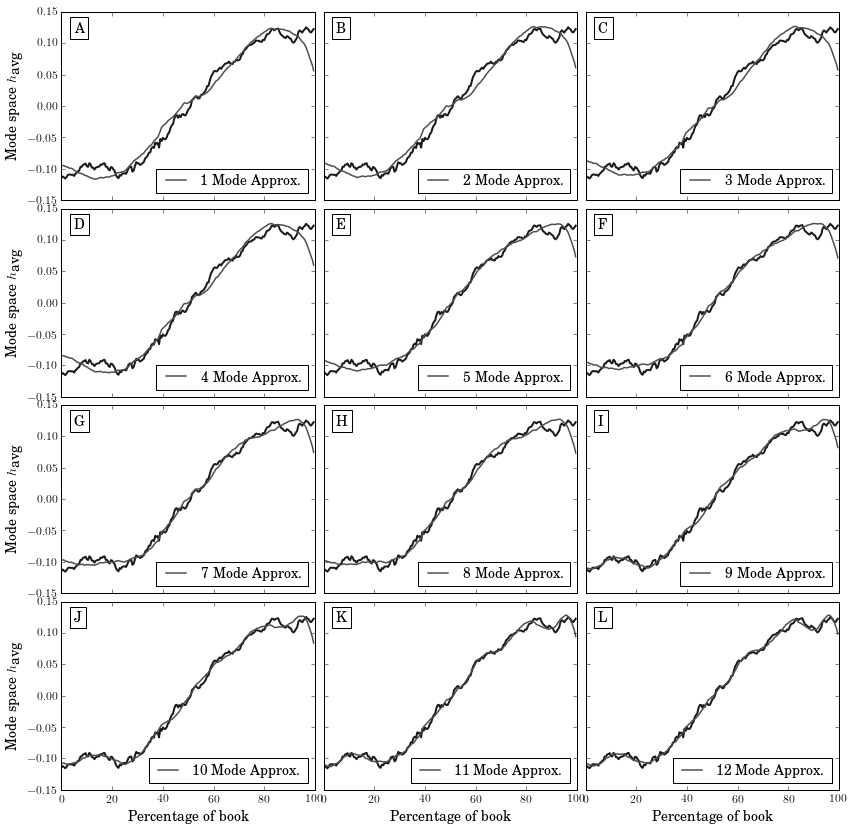

In [146]:
fig = plt.figure(figsize=(12,12))
# plt.title('12 mode reconstruction of {}'.format(b.title[:30]))

n_x = 3
n_y = 4

# whole figure label padding
xpad = .085
ypad = .085
xpadr = .015
ypadr = .015
xpadding= .01
ypadding = .01
# remaining width
xrem = 1.-xpad-xpadr
yrem = 1.-ypad-ypadr
xwidth = (xrem-(n_x-1)*xpadding)/(n_x)
ywidth = (yrem-(n_y-1)*ypadding)/(n_y)

# for i in range(istart,plotsize+1):
                
for k in range(1,13):
    # this is the y
    n = int(np.floor(((k-1)/n_x)))
    # this is the x
    m = (k-1)-n*n_x
    # print(m,n)
    rect = [xpad+m*(xwidth+xpadding),1-ywidth-ypadr-n*(ywidth+ypadding),xwidth,ywidth]
    ax = fig.add_axes(rect)  
    # plt.title('{} mode reconstruction of {}'.format(k,b.title[:30]))
    b,s,i = mode_0_top_pos_norm[0]
    ax.plot(np.arange(0,100,0.5),big_matrix_mean0[i],color=".1",linewidth=2,label=None)
    # print(s,i,b.title)
    reconstruction = np.zeros(V[j,:].shape)
    for j in range(0,k):
        reconstruction += V[j,:]*w[i,j]
    ax.plot(np.arange(0,100,0.5),reconstruction,color=".3",linewidth=1.5,label="{0} Mode Approx.".format(k))
    if m != 0:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel(r"Mode space $h_{\textnormal{avg}}$",fontsize=14)
    if n != (n_y-1):
        # print("no xlabel")
        ax.set_xticklabels([])
    else: 
        ax.set_xlabel("Percentage of book",fontsize=14)
    props = dict(boxstyle='square', facecolor='white', alpha=1.0)
    # fig.text(ax1rect[0]+.03/xwidth, ax1rect[1]+ax1rect[3]-.03/yheight, letters[i],
    my_ylim = ax.get_ylim()
    # ax.text(.035*100, my_ylim[0]+.965*(my_ylim[1]-my_ylim[0]), letters[k-1],
    ax.text(0.05, 0.95, letters[k-1],
                 fontsize=14,
                 verticalalignment='top',
                 horizontalalignment='left',
                 transform=ax.transAxes,
                 bbox=props)
    # ax.text(.05,.95,"A")
    ax.legend(loc="lower right",fontsize=14)
# plt.subplot(4,3,2)
# plt.title('12 mode reconstruction of {}'.format(b.title[:31]),fontsize=20)
mysavefig("example-timeseries-recon-stacked-{}.pdf".format(b.gutenberg_id),folder="media/figures/SVD",openfig=False)

0.532712956226 Alice's Adventures Under Ground
Being a facsimile of the original Ms. book afterwards developed into "Alice's Adventures in Wonderland"
0.447416382437 Dreams
0.443574760541 The Human Comedy: Introductions and Appendix
0.438737219615 The History Of The Decline And Fall Of The Roman Empire
Table of Contents with links in the HTML file to the two
Project Gutenberg editions (12 volumes)
0.435226386826 The Ballad of Reading Gaol
0.423592812272 A Coffin for Jacob
0.422346158367 Handbook of Wool Knitting and Crochet
0.419578114548 Eureka: A Prose Poem
0.418115068024 Adventures of Huckleberry Finn, Chapters 01 to 05
0.413868409342 More About the Squirrels
3.37631311852 A Book of Dartmoor
Second Edition
3.27465171681 The Ladies' Work-Book
Containing Instructions In Knitting, Crochet, Point-Lace, etc.
2.77646889964 The Common Law
2.74513247859 Divine Comedy, Longfellow's Translation, Complete
2.29009544919 Mob Rule in New Orleans
Robert Charles and His Fight to Death, the Story of

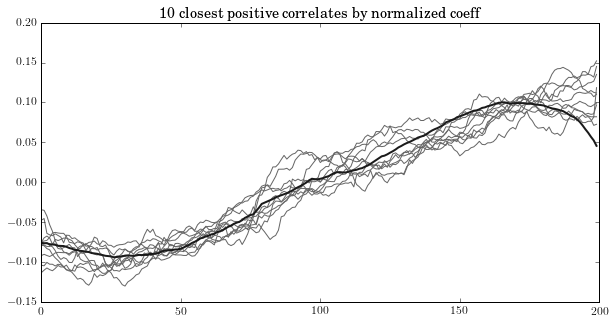

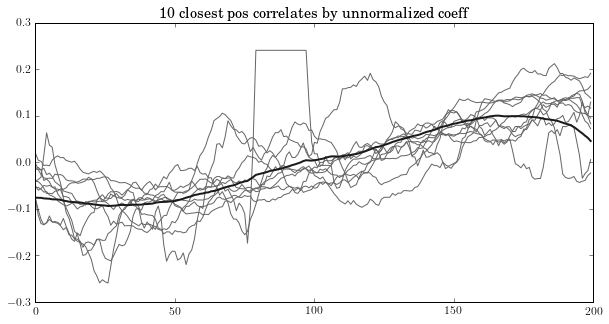

In [147]:
plt.figure(figsize=(10,5))
plt.title('10 closest positive correlates by normalized coeff')
j = 0
for b,s,i in mode_0_top_pos_norm[:10]:
    plt.plot(big_matrix_mean0[i]/np.sum(np.abs(w[i,:]))/s,color=".4")
    # plt.plot(big_matrix_mean0[i],color=".4")
    print(s,b.title)
    j += 1
# plt.plot(V[0,:]*S[0],color=".1",linewidth=2)
plt.plot(V[0,:],color=".1",linewidth=2)

plt.figure(figsize=(10,5))
plt.title('10 closest pos correlates by unnormalized coeff')
j = 0
for b,s,i in mode_0_top_pos[:10]:
    plt.plot(big_matrix_mean0[i]/np.sum(np.abs(w[i,:]))/w_normalized[i,0],color=".4")
    # plt.plot(big_matrix_mean0[i],color=".4")
    print(s,b.title)
    j += 1
# plt.plot(V[0,:]*S[0],color=".1",linewidth=2)
plt.plot(V[0,:],color=".1",linewidth=2)

-0.525455116329 A Primary Reader: Old-time Stories, Fairy Tales and Myths Retold by Children
-0.510810443716 The House of the Vampire
-0.471375050042 Savrola
A Tale of the Revolution in Laurania
-0.460101159824 The Dance (by An Antiquary)
Historic Illustrations of Dancing from 3300 B.C. to 1911 A.D.
-0.45449849335 Romeo and Juliet
-0.449758699012 The Duchess of Malfi
-0.448862038114 Three Ghost Stories
-0.442045077194 Treatises on Friendship and Old Age
-0.440334906626 A Chautauqua Idyl
-0.435777717787 Poems
-3.07227490244 The Principles of Masonic Law
A Treatise on the Constitutional Laws, Usages and Landmarks of
Freemasonry
-3.06054351053 Savrola
A Tale of the Revolution in Laurania
-2.92779491819 The Divine Comedy by Dante, Illustrated
-2.55374740368 The Institutes of Justinian
-2.47540489037 Second Treatise of Government
-2.43798617696 The Last Days of Pompeii
-2.23270187555 The Scarlet Pimpernel
-2.15424336071 The German Classics of the Nineteenth and Twentieth Centuries, Volume 0

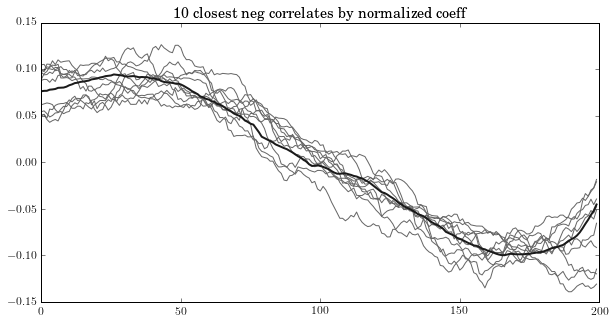

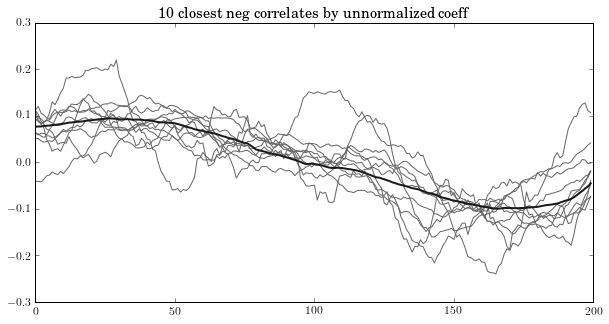

In [148]:
plt.figure(figsize=(10,5))
plt.title('10 closest neg correlates by normalized coeff')
j = 0
for b,s,i in mode_0_top_neg_norm[:10]:
    plt.plot(-big_matrix_mean0[i]/np.sum(np.abs(w[i,:]))/s,color=".4")
    # plt.plot(big_matrix_mean0[i],color=".4")
    print(s,b.title)
    j += 1
# plt.plot(V[0,:]*S[0],color=".1",linewidth=2)
plt.plot(-V[0,:],color=".1",linewidth=2)

plt.figure(figsize=(10,5))
plt.title('10 closest neg correlates by unnormalized coeff')
j = 0
for b,s,i in mode_0_top_neg[:10]:
    plt.plot(-big_matrix_mean0[i]/np.sum(np.abs(w[i,:]))/w_normalized[i,0],color=".4")
    # plt.plot(big_matrix_mean0[i],color=".4")
    print(s,b.title)
    j += 1
# plt.plot(V[0,:]*S[0],color=".1",linewidth=2)
plt.plot(-V[0,:],color=".1",linewidth=2)

## could put these all on the same plot (by flipping them....but the sign matters here!)

again this seems to be an issue with the SVD though.

it is finding the modes that explain the most variance using BOTH versions of the mode

...which is not what we want!! ex: man in the whole is the main story.

it will struggle to find this because it will need to explain with the negative of this!

In [185]:
num_modes = 10

core_emotional_arcs = [sorted(zip(w_normalized[i,:],
                                  range(1,len(w_normalized[i,:])+1)),
                              key=lambda x: np.abs(x[0]),
                              reverse=True) for i,b in enumerate(q)]

pos_stories = [[] for i in range(len(core_emotional_arcs[0]))]
neg_stories = [[] for i in range(len(core_emotional_arcs[0]))]

for i in range(len(core_emotional_arcs)):
    if core_emotional_arcs[i][0][0] > 0:
        pos_stories[core_emotional_arcs[i][0][1]-1].append(i)
    else:
        neg_stories[core_emotional_arcs[i][0][1]-1].append(i)

# check that these types work
m=0
w_normalized[pos_stories[m],m]

all_lists = [{} for i in range(num_modes)]
for m in range(num_modes):
    all_lists[m]["top_abs"] = sorted(zip(q,w[:,m],range(len(q))),key=lambda x: np.abs(x[1]),reverse=True)
    all_lists[m]["top_pos"] = sorted(zip(q,w[:,m],range(len(q))),key=lambda x: -x[1])
    all_lists[m]["top_neg"] = sorted(zip(q,w[:,m],range(len(q))),key=lambda x: x[1])
    all_lists[m]["top_abs_norm"] = sorted(zip(q,w_normalized[:,m],range(len(q))),key=lambda x: np.abs(x[1]),reverse=True)
    all_lists[m]["top_pos_norm"] = sorted(zip(q,w_normalized[:,m],range(len(q))),key=lambda x: -x[1])
    all_lists[m]["top_neg_norm"] = sorted(zip(q,w_normalized[:,m],range(len(q))),key=lambda x: x[1])
    q_mode = [q[i] for i in pos_stories[i]]
    all_lists[m]["top_pos_norm_attached"] = sorted(zip(q_mode,
                                                       w_normalized[pos_stories[m],m],
                                                       range(len(pos_stories[m]))),
                                                   key=lambda x: x[1])
    all_lists[m]["top_pos_norm_attached_downloads"] = sorted(zip(q_mode,
                                                       w_normalized[pos_stories[m],m],
                                                       range(len(pos_stories[m]))),
                                                   key=lambda x: x[0].downloads)
    q_mode = [q[i] for i in neg_stories[i]]
    all_lists[m]["top_neg_norm_attached"] = sorted(zip(q_mode,
                                                       w_normalized[neg_stories[m],m],
                                                       range(len(neg_stories[m]))),
                                                   key=lambda x: x[1])
    all_lists[m]["top_neg_norm_attached_downloads"] = sorted(zip(q_mode,
                                                       w_normalized[neg_stories[m],m],
                                                       range(len(neg_stories[m]))),
                                                   key=lambda x: x[0].downloads)

IndexError: list index out of range

In [175]:
def plot_svs(svstart,v=True,fix_ylim=0.0,xspacing=.01):
    nsvs = 3
    xoffset = .1
    xwidth = (1.-xoffset)/(nsvs)-xspacing
    print('xwidth is {0}'.format(xwidth))
    
    chars = 52
    
    fig = plt.figure(figsize=(15,10))
    for sv in range(0,3):
        print(sv)
        # ind = np.argsort(w[:,sv+svstart])[-20:]
        ax1rect = [xoffset+sv*(xspacing+xwidth),.65,xwidth,.34]
        ax1 = fig.add_axes(ax1rect)
        ax1books = fig.add_axes([xoffset+sv*(xspacing+xwidth),.5,xwidth,.1])
        # ax1books.text?
        # ax.set_title('20 closest positive correlates')
        if v:
            print('-'*80)
            print('20 closest positive correlates:')
        j=0
        for b,s,i in all_lists[sv+svstart]["top_neg_norm"][:20]:
            ax1.plot(np.arange(0,100,0.5),-big_matrix_mean0[i]/np.sum(np.abs(w[i,:]))/s,color=".4",label=None)
            # plt.plot(big_matrix_mean0[i],color=".4")
            if v:
                print(s,b.title)
            if j<5 and not b.exclude:
                if len(b.title) > chars:
                    ax1books.text(0.0,.9-j*.2,'{0}: {1}... ({2})'.format(j+1,b.title[:chars-3].replace("\n",": "),b.gutenberg_id),fontsize=10)
                else:
                    ax1books.text(0.0,.9-j*.2,'{0}: {1} ({2})'.format(j+1,b.title.replace("\n",": "),b.gutenberg_id),fontsize=10)
                j+=1
            # print(b.exclude)
        ax1.plot(np.arange(0,100,0.5),-V[sv+svstart,:],color="#ff6700",linewidth=2,label="SV {}".format(sv+svstart+1))
        # ax1.set_xticklabels([])
        # ax1.set_xticklabels(["0","20","40","60",r"\% of Book",""])
        ax1.set_xticks([10,30,50,70,90])
        ax1.set_xticklabels(["10","30","50","70","90"])
        # ax1.set_xlabel(r"Top stories:~~~~~ ~~~~~ ~~~~~ ~~~~~ ~~~~~ ~~~~~ ~~~~~  ~~~~~ {\normalsize Percentage of book}")
        # ax1.set_xlabel(r"Top stories:~~~~~ ~~~~~ ~~~~~ ~~~~~ ~~~~~ ~~~~~ ~~~~~  ~~~~~ ~~~~~ ~~~~~")
        ax1.text(.98,0.02,r"\% of Book",ha="right",va="bottom",transform=ax1.transAxes)
        ax1books.text(0.0,1.1,"Top Stories:",fontsize=12)
        ax1.legend(loc="upper left")

        #ax1.axis('off')
        ax1books.axis('off')

        ax2 = fig.add_axes([xoffset+sv*(xspacing+xwidth),.15,xwidth,.34])
        ax2books = fig.add_axes([xoffset+sv*(xspacing+xwidth),.0,xwidth,.10])
        # ax2.set_title('20 closest negative correlates')
        if v:
            print('-'*80)
            print('20 closest negative correlates:')
        j=0
        for b,s,i in all_lists[sv+svstart]["top_pos_norm"][:20]:
            ax2.plot(np.arange(0,100,0.5),big_matrix_mean0[i]/np.sum(np.abs(w[i,:]))/s,color=".4",label=None)
            # plt.plot(big_matrix_mean0[i],color=".4")
            if v:
                print(s,b.title)
            if j<5 and not b.exclude:
                if len(b.title) > chars:
                    ax2books.text(0.0,.9-j*.2,'{0}: {1}... ({2})'.format(j+1,b.title[:chars-3].replace("\n",": "),b.gutenberg_id),fontsize=10)
                else:
                    ax2books.text(0.0,.9-j*.2,'{0}: {1} ({2})'.format(j+1,b.title.replace("\n",": "),b.gutenberg_id),fontsize=10)
                j+=1
            # print(b.exclude)
        ax2.plot(np.arange(0,100,0.5),V[sv+svstart,:],color="#ff6700",linewidth=2,label="-- (SV {})".format(sv+svstart+1))
        # ax2.set_xticklabels([])
        # ax2.set_xlabel(r"Top stories:~~~~~ ~~~~~ ~~~~~ ~~~~~ ~~~~~ ~~~~~ ~~~~~ ~~~~~ {\normalsize Percentage of book}")
        ax2.legend(loc="upper left")
        
        # ax2.set_xticklabels(["0","20","40","60",r"\% of Book",""])
        # ax2.set_xticklabels(["0","20","40","60","",""])
        ax2books.text(0.0,1.1,"Top Stories:",fontsize=12)
        
        ax2.set_xticks([10,30,50,70,90])
        ax2.set_xticklabels(["10","30","50","70","90"])
        ax2.text(.99,0.01,r"\% of Book",ha="right",va="bottom",transform=ax2.transAxes)
        
        
        #ax1.axis('off')
        ax2books.axis('off')
        
        if fix_ylim > 0:
            ax1.set_ylim([-fix_ylim,fix_ylim])
            ax2.set_ylim([-fix_ylim,fix_ylim])
        if sv > 0:
            ax1.set_yticklabels([])
            ax2.set_yticklabels([])
        else:
            new_ticks = [x for x in ax1.yaxis.get_ticklocs()]
            ax1.set_yticks(new_ticks)
            ax2.set_yticks(new_ticks)
            print(new_ticks)
            # new_ticks[new_ticks.index(0.0)] = "Happs"
            new_ticks[new_ticks.index(0.0)] = r"""Mode-
space
$h_{\textnormal{avg}}$"""
            
            # ax1.set_yticklabels(new_ticks)
            # ax2.set_yticklabels(new_ticks)
            ax1.set_ylabel(r"""Mode-
space
$h_{\textnormal{avg}}$""",rotation=0)
            ax2.set_ylabel(r"""Mode-
space
$h_{\textnormal{avg}}$""",rotation=0)
            
            
    # mysavefig('SV{0}.svg'.format('4-6'))
    mysavefig("SVD-timeseries-mode-{}-{}.png".format(svstart+1,svstart+4),folder="media/figures/SVD",openfig=False)
    mysavefig("SVD-timeseries-mode-{}-{}.pdf".format(svstart+1,svstart+4),folder="media/figures/SVD",openfig=False)

In [176]:
rc('font', family='serif')
rc('font', family='cmr10')
rc('text', usetex='true') 

rcParams.update({'font.size': 12})
# import matplotlib.pyplot as plt
# %matplotlib inline

xwidth is 0.29
0
[-0.20000000000000001, -0.15000000000000002, -0.10000000000000001, -0.049999999999999989, 0.0, 0.049999999999999989, 0.10000000000000003, 0.15000000000000002, 0.20000000000000001, 0.25]
1
2


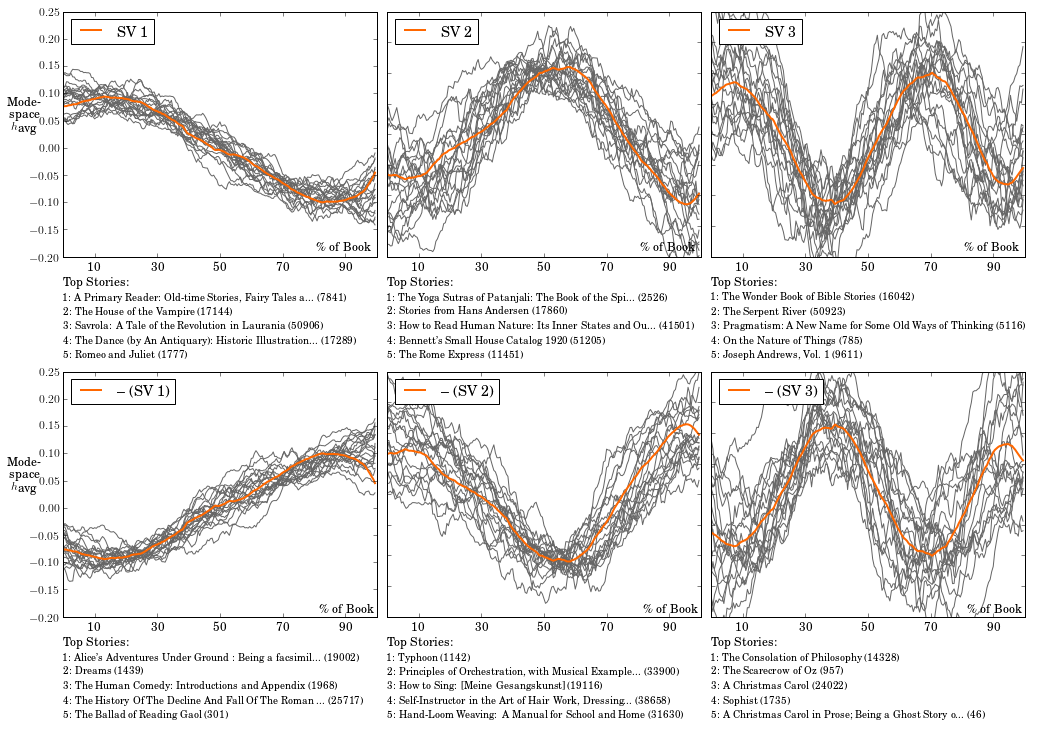

In [177]:
plot_svs(0,v=False,fix_ylim=.2)

xwidth is 0.29
0
[-0.40000000000000002, -0.30000000000000004, -0.20000000000000001, -0.099999999999999978, 0.0, 0.099999999999999978, 0.20000000000000007, 0.30000000000000004, 0.40000000000000002, 0.5]
1
2


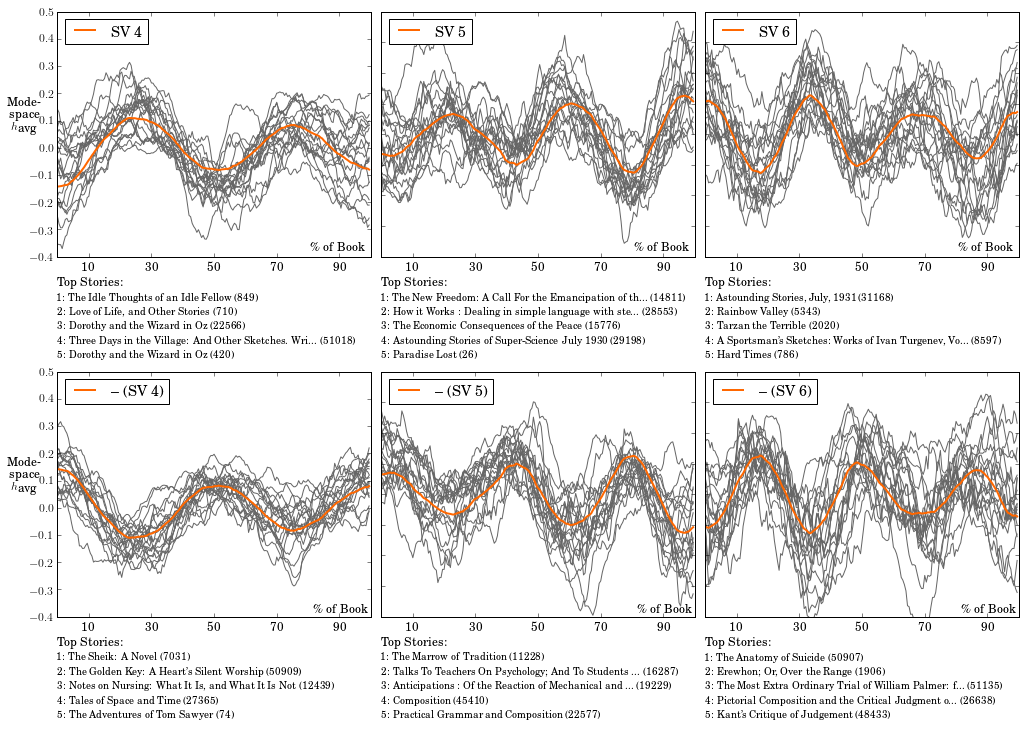

In [153]:
plot_svs(3,v=False,fix_ylim=.4)

the previous analysis took the stories which are closest to the core emotional arcs

but, a story could have been the closest to two different arcs (although very unlikely) with
coefficients that are large for two modes, and 0 for the rest.



so, we need to actually figure out the main core emotional arc for each story

do this by considering the absolute value of the coeff, but keep track of whether it was pos or neg



1 for SV 1, and -1 for -SV 1.

2 for SV 2, and -2 for -SV 2.

In [154]:
core_emotional_arcs = [sorted(zip(w_normalized[i,:],
                                  range(1,len(w_normalized[i,:])+1)),
                              key=lambda x: np.abs(x[0]),
                              reverse=True) for i,b in enumerate(q)]

In [155]:
print(core_emotional_arcs[0])

[(0.20722030740141045, 2), (-0.08898345125027031, 1), (0.072247362069774196, 3), (0.041276179104402337, 4), (0.031635951123605288, 7), (0.029651305028689269, 5), (-0.026608102389792092, 9), (0.025257242997775781, 12), (-0.024482246393789316, 8), (-0.021669607916913448, 20), (-0.019874990401201092, 19), (0.016811221462474369, 6), (0.013754613565395231, 11), (-0.011591128490223163, 17), (0.010109314065422381, 28), (0.0087514342717458279, 43), (-0.0087217457563927188, 14), (-0.0085526515011983897, 38), (-0.0077772870710854152, 13), (-0.0075837793166997599, 44), (-0.0075615419988365584, 23), (-0.0074040001951322472, 24), (0.0069521266335874068, 51), (-0.0068333179328767977, 31), (-0.0065024527081289319, 10), (-0.0062769821893325422, 80), (-0.0061867173945547495, 27), (0.0060327011128414989, 59), (0.0057732557100246325, 29), (-0.0055312138633391312, 54), (-0.005477618596321389, 40), (-0.0052900168474512158, 84), (-0.0052439768631784463, 15), (0.0050841231519040886, 32), (-0.0048810681985697

In [178]:
pos_stories = [[] for i in range(len(core_emotional_arcs[0]))]
neg_stories = [[] for i in range(len(core_emotional_arcs[0]))]

for i in range(len(core_emotional_arcs)):
    if core_emotional_arcs[i][0][0] > 0:
        pos_stories[core_emotional_arcs[i][0][1]-1].append(i)
    else:
        neg_stories[core_emotional_arcs[i][0][1]-1].append(i)

In [157]:
# this should start with book 0 from above
pos_stories[1][:10]

[0, 17, 21, 26, 62, 75, 116, 118, 147, 151]

In [158]:
print(list(map(len,pos_stories))[:14])

[263, 227, 105, 108, 50, 16, 19, 11, 5, 11, 3, 5, 1, 1]


In [159]:
print(list(map(len,neg_stories))[:32])

[436, 165, 109, 50, 48, 40, 25, 14, 10, 3, 1, 3, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5]


In [160]:
print(len(q))
all_downloads = [b.downloads for b in q]
print(np.mean(all_downloads))
book_indices = [0,10,100,1000]
these_downloads = [q[i].downloads for i in book_indices]
print(np.mean(these_downloads))
print(these_downloads)
print(np.sum(these_downloads>np.mean(all_downloads))/len(these_downloads)*100)

1737
668.035693725
2519.0
[673, 730, 7652, 1021]
100.0


In [161]:
def core_stats(book_indices):
    N = len(book_indices)
    percentage = N/len(q)*100
    these_downloads = [q[i].downloads for i in book_indices]
    percentage_more = np.sum(these_downloads>np.mean(all_downloads))/len(these_downloads)*100
    return N,percentage,np.mean(these_downloads),np.median(these_downloads),these_downloads,np.var(these_downloads),percentage_more

SV 2 (230, 13.18051575931232, 601.42173913043473, 334.5)
(array([  0.,   0.,  12.,  32.,  31.,  13.,  19.,  19.,  17.,  12.,   8.,
        13.,   6.,  12.,   7.,   8.,   6.,   3.,   2.,   2.,   3.,   3.,
         1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
         0.,   0.]), array([ 2.  ,  2.07,  2.14,  2.21,  2.28,  2.35,  2.42,  2.49,  2.56,
        2.63,  2.7 ,  2.77,  2.84,  2.91,  2.98,  3.05,  3.12,  3.19,
        3.26,  3.33,  3.4 ,  3.47,  3.54,  3.61,  3.68,  3.75,  3.82,
        3.89,  3.96,  4.03,  4.1 ,  4.17,  4.24,  4.31,  4.38,  4.45]), <a list of 35 Patch objects>)
35
36
(0.0, 35.0)
2.5243961221
7
19.0


(0.0, 100.0, -0.15000000000000002, 0.15000000000000002)

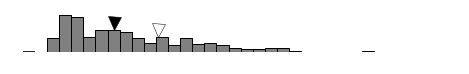

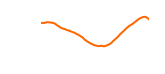

In [107]:
i = 1
stats = core_stats(pos_stories[i])
print("SV {}".format(i+1),stats[:4])
fig = plt.figure(figsize=(6,.55))
ax = fig.add_axes([0,0,1,1])
# ax.set_xlim([100,1000])
# ax.hist(stats[4],bins=np.arange(100,20000,100),color=".5")
# ax.hist(stats[4],color=".5")
a = ax.hist(np.log10(stats[4]),bins=np.arange(2.0,4.5,.07),color=".5")
print(a)
print(len(a[0]))
print(len(a[1]))
ax.plot([2.0,4.5],[0.0,0.0],linewidth=0.5,color=".7")
ax.set_xlim([2.0,4.5])
print(ax.get_ylim())
y_range = ax.get_ylim()[1]
# ax.text(np.log10(stats[3]),10,r'$\triangledown$')
def find_bin_i(bins,x):
    j = 0
    while bins[j] < x:
        j+=1
    return j-1
print(np.log10(stats[3]))
print(find_bin_i(a[1],np.log10(stats[3])))
print(a[0][find_bin_i(a[1],np.log10(stats[3]))])
ax.plot(np.log10(stats[3]),a[0][find_bin_i(a[1],np.log10(stats[3]))]+y_range*.17,'kv',markersize=13)
ax.plot(np.log10(stats[2]),a[0][find_bin_i(a[1],np.log10(stats[2]))]+y_range*.17,'kv',fillstyle='none',markersize=13)
# ax.set_xlim([100,20000])
ax.axis("off")
fig = plt.figure(figsize=(1.5,.55))
ax = fig.add_axes([0,0,1,1])
ax.plot(np.arange(0,100,0.5),V[i,:],color="#ff6700",linewidth=2)
ax.axis("off")

In [108]:
for i in range(15):
    stats = core_stats(pos_stories[i])
    print("SV {}".format(i+1),stats[:4])
    fig = plt.figure(figsize=(6,.55))
    ax = fig.add_axes([0,0,1,1])
    # ax.set_xlim([100,1000])
    # ax.hist(stats[4],bins=np.arange(100,20000,100),color=".5")
    # ax.hist(stats[4],color=".5")
    a = ax.hist(np.log10(stats[4]),bins=np.arange(2.0,4.5,.07),color=".5")
    ax.plot([2.0,4.5],[0.0,0.0],linewidth=0.5,color=".7")
    ax.set_xlim([2.0,4.5])
    y_range = ax.get_ylim()[1]
    ax.plot(np.log10(stats[3]),a[0][find_bin_i(a[1],np.log10(stats[3]))]+y_range*.17,'kv',markersize=13)
    ax.plot(np.log10(stats[2]),a[0][find_bin_i(a[1],np.log10(stats[2]))]+y_range*.17,'kv',markersize=13,fillstyle='none')
    # ax.set_xlim([100,20000])
    ax.axis("off")
    mysavefig("SV{0}-+-sparkhist.pdf".format(i+1),folder="media/figures/SVD/",date=False,openfig=False)
    call("pdfcrop media/figures/SVD/SV{0}-+-sparkhist.pdf".format(i+1),shell=True)
    call("mv media/figures/SVD/SV{0}-+-sparkhist{{-crop,}}.pdf".format(i+1),shell=True)
    plt.close(fig)
    fig = plt.figure(figsize=(1.5,.55))
    ax = fig.add_axes([0,0,1,1])
    ax.plot(np.arange(0,100,0.5),V[i,:],color="#ff6700",linewidth=2)
    ax.axis("off")
    mysavefig("SV{0}-+-spark.pdf".format(i+1),folder="media/figures/SVD/",date=False,openfig=False)
    call("pdfcrop media/figures/SVD/SV{0}-+-spark.pdf".format(i+1),shell=True)
    call("mv media/figures/SVD/SV{0}-+-spark{{-crop,}}.pdf".format(i+1),shell=True)
    plt.close(fig)
    stats = core_stats(neg_stories[i])
    print("-SV {}".format(i+1),stats[:4])
    fig = plt.figure(figsize=(6,.55))
    ax = fig.add_axes([0,0,1,1])
    a = ax.hist(np.log10(stats[4]),bins=np.arange(2.0,4.5,.07),color=".5")
    ax.plot([2.0,4.5],[0.0,0.0],linewidth=0.5,color=".7")
    ax.set_xlim([2.0,4.5])
    y_range = ax.get_ylim()[1]
    ax.plot(np.log10(stats[3]),a[0][find_bin_i(a[1],np.log10(stats[3]))]+y_range*.17,'kv',markersize=13)
    ax.plot(np.log10(stats[2]),a[0][find_bin_i(a[1],np.log10(stats[2]))]+y_range*.17,'kv',markersize=13,fillstyle='none')
    ax.axis("off")
    mysavefig("SV{0}---sparkhist.pdf".format(i+1),folder="media/figures/SVD/",date=False,openfig=False)
    call("pdfcrop media/figures/SVD/SV{0}---sparkhist.pdf".format(i+1),shell=True)
    call("mv media/figures/SVD/SV{0}---sparkhist{{-crop,}}.pdf".format(i+1),shell=True)
    plt.close(fig)
    fig = plt.figure(figsize=(1.5,.55))
    ax = fig.add_axes([0,0,1,1])
    ax.plot(np.arange(0,100,0.5),-V[i,:],color="#ff6700",linewidth=2)
    ax.axis("off")
    mysavefig("SV{0}---spark.pdf".format(i+1),folder="media/figures/SVD/",date=False,openfig=False)
    call("pdfcrop media/figures/SVD/SV{0}---spark.pdf".format(i+1),shell=True)
    call("mv media/figures/SVD/SV{0}---spark{{-crop,}}.pdf".format(i+1),shell=True)
    plt.close(fig)

SV 1 (262, 15.014326647564468, 632.84732824427476, 292.5)
-SV 1 (441, 25.272206303724925, 617.59183673469386, 321.0)
SV 2 (230, 13.18051575931232, 601.42173913043473, 334.5)
-SV 2 (169, 9.684813753581661, 568.76923076923072, 281.0)
SV 3 (104, 5.959885386819484, 666.50961538461536, 302.5)
-SV 3 (108, 6.189111747851003, 888.32407407407402, 312.5)
SV 4 (108, 6.189111747851003, 909.37037037037032, 321.5)
-SV 4 (50, 2.865329512893983, 835.20000000000005, 313.0)
SV 5 (48, 2.7507163323782233, 553.33333333333337, 285.0)
-SV 5 (48, 2.7507163323782233, 535.97916666666663, 336.5)
SV 6 (15, 0.8595988538681949, 495.06666666666666, 313.0)
-SV 6 (40, 2.292263610315186, 733.95000000000005, 309.0)
SV 7 (21, 1.2034383954154728, 723.57142857142856, 424.0)
-SV 7 (25, 1.4326647564469914, 507.27999999999997, 260.0)
SV 8 (12, 0.6876790830945558, 475.5, 277.5)
-SV 8 (12, 0.6876790830945558, 756.16666666666663, 264.5)
SV 9 (5, 0.28653295128939826, 2990.0, 528.0)
-SV 9 (7, 0.40114613180515757, 559.0, 384.0)
SV 

/Users/andyreagan/projects/2014/09-books/pyvenv/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in long_scalars


/Users/andyreagan/projects/2014/09-books/pyvenv/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)

  warnings.warn("Mean of empty slice.", RuntimeWarning)

/Users/andyreagan/projects/2014/09-books/pyvenv/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

  ret = ret.dtype.type(ret / rcount)

/Users/andyreagan/projects/2014/09-books/pyvenv/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)

  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)

/Users/andyreagan/projects/2014/09-books/pyvenv/lib/p

 (1, 0.05730659025787965, 177.0, 177.0)
-SV 14 (0, 0.0, nan, nan)
SV 15 (0, 0.0, nan, nan)
-SV 15 (1, 0.05730659025787965, 902.0, 902.0)


In [117]:
f = open("media/figures/SVD/SVD-table-point5.tex","w")
f.write(r"\begin{tabular}{c | c | c | c | c | c | c | c | c}")
f.write("\n")
f.write(r"Mode & Mode Arc & $N_m$ & $N_m/N$ & DL Median $\blacktriangledown$ & DL Mean $\triangledown$ & DL Variance & \% $>$ Average & Download Distribution \\")
f.write("\n")
f.write(r"\hline")
# f.write("\n")
# f.write(r"\hline")
f.write("\n")
for i in range(10):
    stats = core_stats(pos_stories[i])
    if stats[1] > .5:
        print("SV {}".format(i+1),stats[:4])
        f.write(r"SV {0} & \adjustimage{{height=12px,width=45px,valign=m}}{{SV{0}-+-spark.pdf}} & {1} & {2:.1f}\%".format(i+1,stats[0],stats[1]))
        f.write(r" & {2:.1f} & {1:.1f} & {3:.0f} & {4:.1f}\%".format(i+1,stats[2],stats[3],stats[5],stats[6]))
        f.write(r" & \adjustimage{{height=13px,width=110px,valign=m}}{{SV{0}-+-sparkhist.pdf}} \\".format(i+1))
        f.write("\n")
    stats = core_stats(neg_stories[i])
    if stats[1] > .5:
        print("-SV {}".format(i+1),stats[:4])
        f.write(r"-SV {0} & \adjustimage{{height=12px,width=45px,valign=m}}{{SV{0}---spark.pdf}} & {1} & {2:.1f}\%".format(i+1,stats[0],stats[1]))
        f.write(r" & {2:.1f} & {1:.1f} & {3:.0f} & {4:.1f}\%".format(i+1,stats[2],stats[3],stats[5],stats[6]))
        f.write(r" & \adjustimage{{height=13px,width=110px,valign=m}}{{SV{0}---sparkhist.pdf}} \\".format(i+1))
        f.write("\n")
f.write(r"\end{tabular}")
f.close()
f = open("media/figures/SVD/tmp.tex","w")
f.write(r"\input{SVD-table-point5}")
f.write("\n")
f.close()
call("pdflatex table-wrapper",shell=True,cwd="/Users/andyreagan/projects/2014/09-books/media/figures/SVD")
call("pdfcrop media/figures/SVD/table-wrapper.pdf",shell=True)
call("mv media/figures/SVD/table-wrapper-crop.pdf media/figures/SVD/SVD-table-point5.pdf",shell=True)
call("open media/figures/SVD/SVD-table-point5.pdf",shell=True)

f = open("media/figures/SVD/SVD-table-2point5.tex","w")
f.write(r"\begin{tabular}{c | c | c | c | c | c | c | c | c}")
f.write("\n")
f.write(r"Mode & Mode Arc & $N_m$ & $N_m/N$ & DL Median $\blacktriangledown$ & DL Mean $\triangledown$ & DL Variance & \% $>$ Average & Download Distribution \\")
f.write("\n")
f.write(r"\hline")
# f.write("\n")
# f.write(r"\hline")
f.write("\n")
for i in range(10):
    stats = core_stats(pos_stories[i])
    if stats[1] > 2.5:
        print("SV {}".format(i+1),stats[:4])
        f.write(r"SV {0} & \adjustimage{{height=12px,width=45px,valign=m}}{{SV{0}-+-spark.pdf}} & {1} & {2:.1f}\%".format(i+1,stats[0],stats[1]))
        f.write(r" & {2:.1f} & {1:.1f} & {3:.0f} & {4:.1f}\%".format(i+1,stats[2],stats[3],stats[5],stats[6]))
        f.write(r" & \adjustimage{{height=13px,width=110px,valign=m}}{{SV{0}-+-sparkhist.pdf}} \\".format(i+1))
        f.write("\n")
    stats = core_stats(neg_stories[i])
    if stats[1] > 2.5:
        print("-SV {}".format(i+1),stats[:4])
        f.write(r"-SV {0} & \adjustimage{{height=12px,width=45px,valign=m}}{{SV{0}---spark.pdf}} & {1} & {2:.1f}\%".format(i+1,stats[0],stats[1]))
        f.write(r" & {2:.1f} & {1:.1f} & {3:.0f} & {4:.1f}\%".format(i+1,stats[2],stats[3],stats[5],stats[6]))
        f.write(r" & \adjustimage{{height=13px,width=110px,valign=m}}{{SV{0}---sparkhist.pdf}} \\".format(i+1))
        f.write("\n")
f.write(r"\end{tabular}")
f.close()
f = open("media/figures/SVD/tmp.tex","w")
f.write(r"\input{SVD-table-2point5}")
f.write("\n")
f.close()
call("pdflatex table-wrapper",shell=True,cwd="/Users/andyreagan/projects/2014/09-books/media/figures/SVD")
call("pdfcrop media/figures/SVD/table-wrapper.pdf",shell=True)
call("mv media/figures/SVD/table-wrapper-crop.pdf media/figures/SVD/SVD-table-2point5.pdf",shell=True)
call("open media/figures/SVD/SVD-table-2point5.pdf",shell=True)

SV 1 (262, 15.014326647564468, 632.84732824427476, 292.5)
-SV 1 (441, 25.272206303724925, 617.59183673469386, 321.0)
SV 2 (230, 13.18051575931232, 601.42173913043473, 334.5)
-SV 2 (169, 9.684813753581661, 568.76923076923072, 281.0)
SV 3 (104, 5.959885386819484, 666.50961538461536, 302.5)
-SV 3 (108, 6.189111747851003, 888.32407407407402, 312.5)
SV 4 (108, 6.189111747851003, 909.37037037037032, 321.5)
-SV 4 (50, 2.865329512893983, 835.20000000000005, 313.0)
SV 5 (48, 2.7507163323782233, 553.33333333333337, 285.0)
-SV 5 (48, 2.7507163323782233, 535.97916666666663, 336.5)
SV 6 (15, 0.8595988538681949, 495.06666666666666, 313.0)
-SV 6 (40, 2.292263610315186, 733.95000000000005, 309.0)
SV 7 (21, 1.2034383954154728, 723.57142857142856, 424.0)
-SV 7 (25, 1.4326647564469914, 507.27999999999997, 260.0)
SV 8 (12, 0.6876790830945558, 475.5, 277.5)
-SV 8 (12, 0.6876790830945558, 756.16666666666663, 264.5)
SV 10 (13, 0.7449856733524355, 557.53846153846155, 350.0)
SV 1 (262, 15.014326647564468, 632.

0